In [1]:
#1. open high low가 훈련데이터, close가 테스트데이터

# 2. meantemp 예측

In [2]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SimpleRNN, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [3]:
df = read_csv('D:/Son/3-2/deeplearning/report/dataset/train.csv')

df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [4]:
df_selected = df[(df['종목코드'] == 'A095570')]
df_selected

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2001,20210602,A095570,AJ네트웍스,39320,5840,5840,5750,5800
4001,20210603,A095570,AJ네트웍스,78440,5800,5800,5650,5720
6001,20210604,A095570,AJ네트웍스,198246,5720,5720,5420,5570
8001,20210607,A095570,AJ네트웍스,167712,5650,5660,5370,5420
...,...,...,...,...,...,...,...,...
978001,20230523,A095570,AJ네트웍스,83616,4430,4445,4405,4430
980001,20230524,A095570,AJ네트웍스,251478,4430,4515,4380,4450
982001,20230525,A095570,AJ네트웍스,83314,4450,4490,4400,4415
984001,20230526,A095570,AJ네트웍스,206735,4445,4445,4320,4325


In [5]:
df_selected = df_selected.drop(['일자','종목코드','종목명','거래량'], axis=1)
df_selected

,시가,고가,저가,종가
1,5860,5940,5750,5780
2001,5840,5840,5750,5800
4001,5800,5800,5650,5720
6001,5720,5720,5420,5570
8001,5650,5660,5370,5420
...,...,...,...,...
978001,4430,4445,4405,4430
980001,4430,4515,4380,4450
982001,4450,4490,4400,4415
984001,4445,4445,4320,4325


In [6]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)

    return numerator / (denominator + 1e-7)

In [7]:
dfx = df_selected[['시가', '고가', '저가', '종가']]
dfx = MinMaxScaler(dfx)

dfy = dfx[['종가']]
dfx = dfx[['시가', '고가', '저가']]

dfx, dfy

(              시가        고가        저가
 1       0.374536  0.380074  0.368020
 2001    0.369592  0.355474  0.368020
 4001    0.359703  0.345633  0.342640
 6001    0.339926  0.325953  0.284264
 8001    0.322621  0.311193  0.271574
 ...          ...       ...       ...
 978001  0.021014  0.012300  0.026650
 980001  0.021014  0.029520  0.020305
 982001  0.025958  0.023370  0.025381
 984001  0.024722  0.012300  0.005076
 986001  0.000000  0.000000  0.000000
 
 [494 rows x 3 columns],
               종가
 1       0.357934
 2001    0.362854
 4001    0.343173
 6001    0.306273
 8001    0.269373
 ...          ...
 978001  0.025830
 980001  0.030750
 982001  0.022140
 984001  0.000000
 986001  0.001230
 
 [494 rows x 1 columns])

In [8]:
time_step = 5
step = 1

def create_dataset(x, y, time_step, step):
    xs, ys = [], []

    for i in range(0, len(x) - time_step, step):
        v = x.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        xs.append(v)
        ys.append(labels)

    return np.array(xs), np.array(ys)

In [9]:
x, y = create_dataset(dfx, dfy, time_step, step)

x.shape

(489, 5, 3)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((391, 5, 3), (98, 5, 3), (391, 1), (98, 1))

In [11]:
# LSTM

model_LSTM = Sequential([
    LSTM(20, activation='relu', input_shape=(x.shape[1:]), return_sequences=True),
    LSTM(20, activation='relu'),
    Dropout(0.3),
    Flatten(),
    Dense(10,activation='relu'),
    Dense(1)
])

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 20)             1920      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5,421
Trainable params: 5,421
Non-trainabl

In [12]:
model_LSTM.compile(loss='mse', optimizer='adam')

In [13]:
history_LSTM = model_LSTM.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.1, shuffle=False)

Epoch 1/100
22/22 [==============================] - 3s 19ms/step - loss: 0.2235 - val_loss: 0.1177
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.1570 - val_loss: 0.0630
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0645 - val_loss: 0.0044
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.0024
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0209 - val_loss: 0.0012
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0017
Epoch 7/100
22/22 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0012
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0160 - val_loss: 0.0011
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0010
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0010
Epoch 11

22/22 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 83/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 9.8507e-04
Epoch 84/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 85/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 86/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 87/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 88/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0017
Epoch 89/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 90/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 91/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 92/

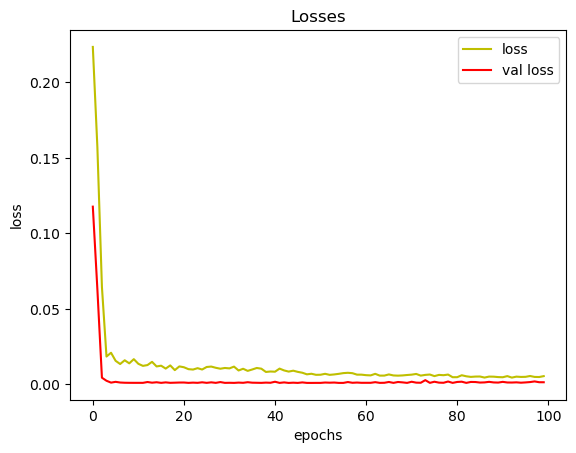

In [14]:
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

x = np.arange(0, len(history_LSTM.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
model_LSTM.evaluate(x_test, y_test)
y_pred = model_LSTM.predict(x_test)

4/4 [==============================] - 0s 2ms/step


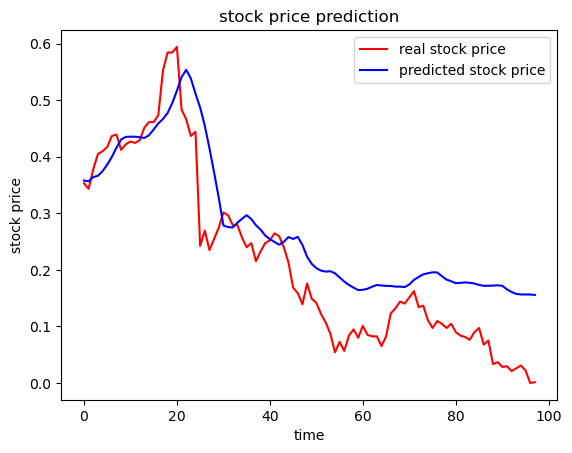

In [16]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

In [17]:
# CNN

model_CNN = Sequential()
model_CNN.add(Conv1D(filters=20,activation='relu', input_shape=(x_train.shape[1:]), padding='same', kernel_size=3))
model_CNN.add(Conv1D(filters=20, activation='relu', padding='same', kernel_size=3))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(10,activation='relu'))
model_CNN.add(Dense(1))

model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 20)             200       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 20)             1220      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 20)            0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                410       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                      

In [18]:
model_CNN.compile(loss='mse', optimizer='adam')

In [19]:
history_CNN = model_CNN.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.1, shuffle=False)

Epoch 1/100
22/22 [==============================] - 1s 7ms/step - loss: 0.0454 - val_loss: 0.0165
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0039
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0029
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 8/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 9/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 10/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 11/

22/22 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 84/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 85/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 86/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 87/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 88/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 89/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 90/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 91/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 92/100
22/22 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 93/100


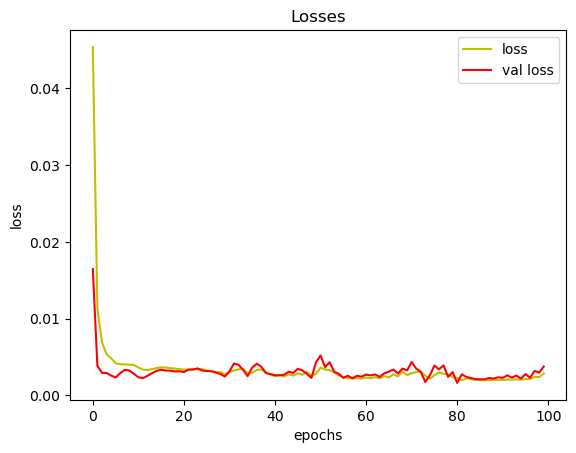

In [20]:
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

x = np.arange(0, len(history_CNN.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
model_CNN.evaluate(x_test, y_test)
y_pred = model_CNN.predict(x_test)

4/4 [==============================] - 0s 998us/step


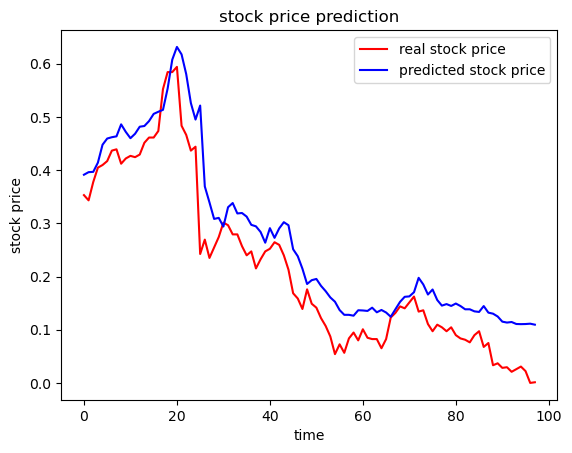

In [22]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()